In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

# import os
# while 'jupyter' in os.getcwd():
#     os.chdir("../")

!pwd

/teamspace/studios/this_studio/ExcitationPullbacks


In [2]:
import platform
platform.machine()

'x86_64'

In [3]:
import torch
from torch import nn, einsum
from torchvision.datasets import Imagenette
from torch.utils.data import DataLoader

import torch.nn.functional as F
from torchvision import transforms as T

from lib.dataset import get_dataset, get_examples, FromMyNormalizeToImageNet
from lib.pga import PGA
from lib.helpers import plot_example_grid, replace_module_with_custom_, maxpool2d_param_extractor, plot_function, show_images
from lib.modules import SurrogateSoftMaxPool2d, TwoWayReLU

In [4]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
device = torch.device(device)
device

device(type='cuda')

In [33]:
dataset = get_dataset(download=True)
# dataset = get_dataset(download=False)

seed = 314
generator = torch.Generator().manual_seed(seed)
loader = DataLoader(dataset, batch_size=5, shuffle=True, generator=generator)

tensor(-1.) tensor(1.) tensor(-0.1605) tensor(0.5643)
images.shape = torch.Size([5, 3, 224, 224])
labels = [0, 482, 497, 569, 574]


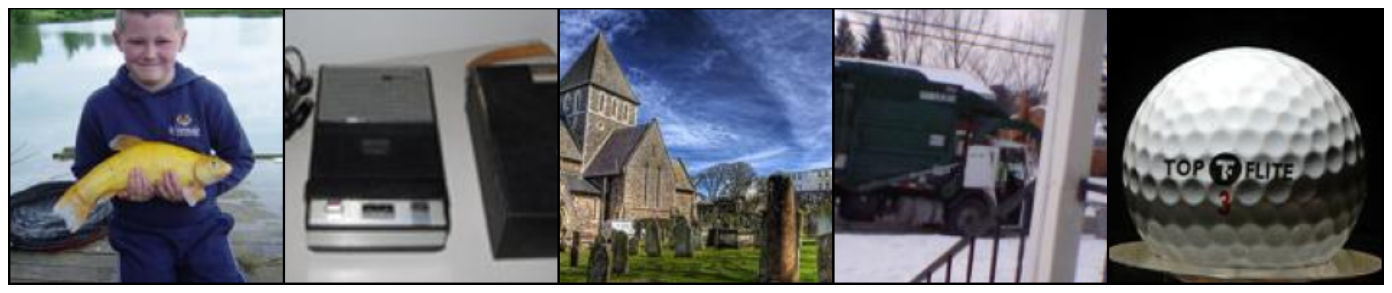

In [34]:
images, labels = get_examples(loader)

print(images.min(), images.max(), images.mean(), images.std())
print(f"images.shape = {images.shape}")
print(f"labels = {labels.tolist()}")

plot_example_grid(images, nrow=5)

In [39]:
k = 5 + 1
random = 9
random_name = "ostrich"
class_names = ["original", "tench", "cassette player", "church", "garbage truck", "golf ball", random_name]

# Repeat images k times (e.g. [img0, img0, ..., img4, img4])
images_repeated = images.repeat_interleave(k, dim=0)  # shape: [5*k, 3, 224, 224]

# Repeat labels: list [0, 2, 4, 6, 8] -> each label k times
labels = torch.cat([labels, torch.tensor([random])], dim=0)
labels_repeated = labels.repeat(k-1)  # shape: [5*k]

images_repeated.shape, labels_repeated.shape

(torch.Size([30, 3, 224, 224]), torch.Size([30]))

In [40]:
images = images.to(device)
images_repeated = images_repeated.to(device)

In [16]:
from torchvision.models import resnet50, vgg11_bn, densenet121

model_cls = resnet50
# model_cls = densenet121
# model_cls = vgg11_bn

backbone_std = model_cls(pretrained=True)
backbone = model_cls(pretrained=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
model = nn.Sequential(
    FromMyNormalizeToImageNet(), backbone
).to(device)

model_std = nn.Sequential(
    FromMyNormalizeToImageNet(), backbone_std
).to(device)

model.eval(), model_std.eval()
model.training, model_std.training

(False, False)

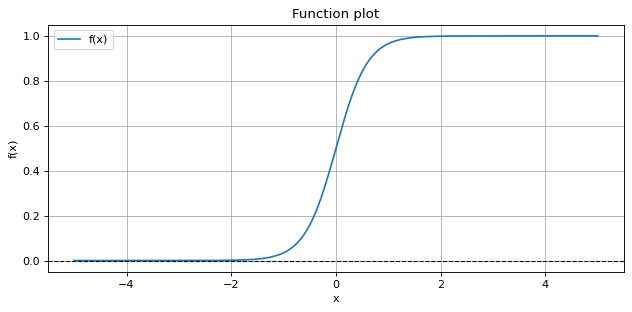

In [18]:
temp = 0.3
f = lambda x: F.sigmoid(x / temp)
plot_function(f)

In [19]:
params = maxpool2d_param_extractor(model[1].maxpool)
params

{'kernel_size': 3,
 'stride': 2,
 'padding': 1,
 'dilation': 1,
 'return_indices': False,
 'ceil_mode': False}

In [20]:
fnc = lambda **params: SurrogateSoftMaxPool2d(**params, temperature=0.4)
fnc(**params)


SurrogateSoftMaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False, temperature=0.4)

In [21]:
temp = 0.3

replace_module_with_custom_(model, lambda: TwoWayReLU(temperature=temp), original_cls=nn.ReLU)#, by_name='relu')
# replace_module_with_custom_(model, lambda: TwoWayReLU(temperature=temp), original_cls=TwoWayReLU)

replace_module_with_custom_(model, lambda **params: SurrogateSoftMaxPool2d(**params, temperature=temp), original_cls=nn.MaxPool2d, param_extractor=maxpool2d_param_extractor)
# replace_module_with_custom_(model, lambda **params: SurrogateSoftMaxPool2d(**params, temperature=temp), original_cls=SurrogateSoftMaxPool2d, param_extractor=maxpool2d_param_extractor)


In [22]:
model
# model_std

Sequential(
  (0): FromMyNormalizeToImageNet(
    (imagenet_norm): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )
  (1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): TwoWayReLU(temperature=0.3)
    (maxpool): SurrogateSoftMaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False, temperature=0.3)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): 

In [23]:
torch.norm(images.flatten(1), dim=1)

tensor([202.3111, 259.2311, 199.0395, 194.7429, 283.3521], device='cuda:0')

In [57]:
# use_cross_entropy_loss = True
use_cross_entropy_loss = False

alpha = 20

eps = 100

# relative_alpha = True
relative_alpha = False
# steps = 1
# steps = 3
steps = 5
# steps = 7
# steps = 10
# steps = 15
# steps = 30

clip_margin = .0
pnorm = 2

self_explain = False
# self_explain = True

In [58]:
# | Class            | Index  | Label name from ImageNet                    |
# | ---------------- | :----: | ------------------------------------------- |
# | tench            |    0   | tench, Tinca tinca ([gist.github.com][1])   |
# | English springer |   217  | English springer, English springer spaniel  |
# | cassette player  |   482  | cassette player                             |
# | chain saw        |   491  | chain saw, chainsaw                         |
# | church           |   497  | church, church building                     |
# | French horn      |   566  | French horn, horn                           |
# | garbage truck    |   569  | garbage truck, dustcart                     |
# | gas pump         |   571  | gas pump, gasoline pump, petrol pump        |
# | golf ball        |   574  | golf ball                                   |
# | parachute        |   701  | parachute, chute                            |

# [1]: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a "text: imagenet 1000 class idx to human readable labels (Fox, E ..."

In [59]:
atk = PGA(model, eps=eps, alpha=alpha, steps=steps, clip_margin=clip_margin, self_explain=self_explain,
          use_cross_entropy_loss=use_cross_entropy_loss, pnorm=pnorm, relative_alpha=relative_alpha)
atk.set_mode_targeted_by_label()

adv_images, grad = atk(images_repeated, labels_repeated)

Attack mode is changed to 'targeted(label)'.


In [60]:
atk = PGA(model_std, eps=eps, alpha=alpha, steps=steps, clip_margin=clip_margin, self_explain=self_explain,
          use_cross_entropy_loss=use_cross_entropy_loss, pnorm=pnorm, relative_alpha=relative_alpha)
atk.set_mode_targeted_by_label()

adv_images_std, grad_std = atk(images_repeated, labels_repeated)

Attack mode is changed to 'targeted(label)'.


In [61]:
show_adv, show_diff = show_images(images, adv_images, k=k)
show_adv_std, show_diff_std = show_images(images, adv_images_std, k=k)

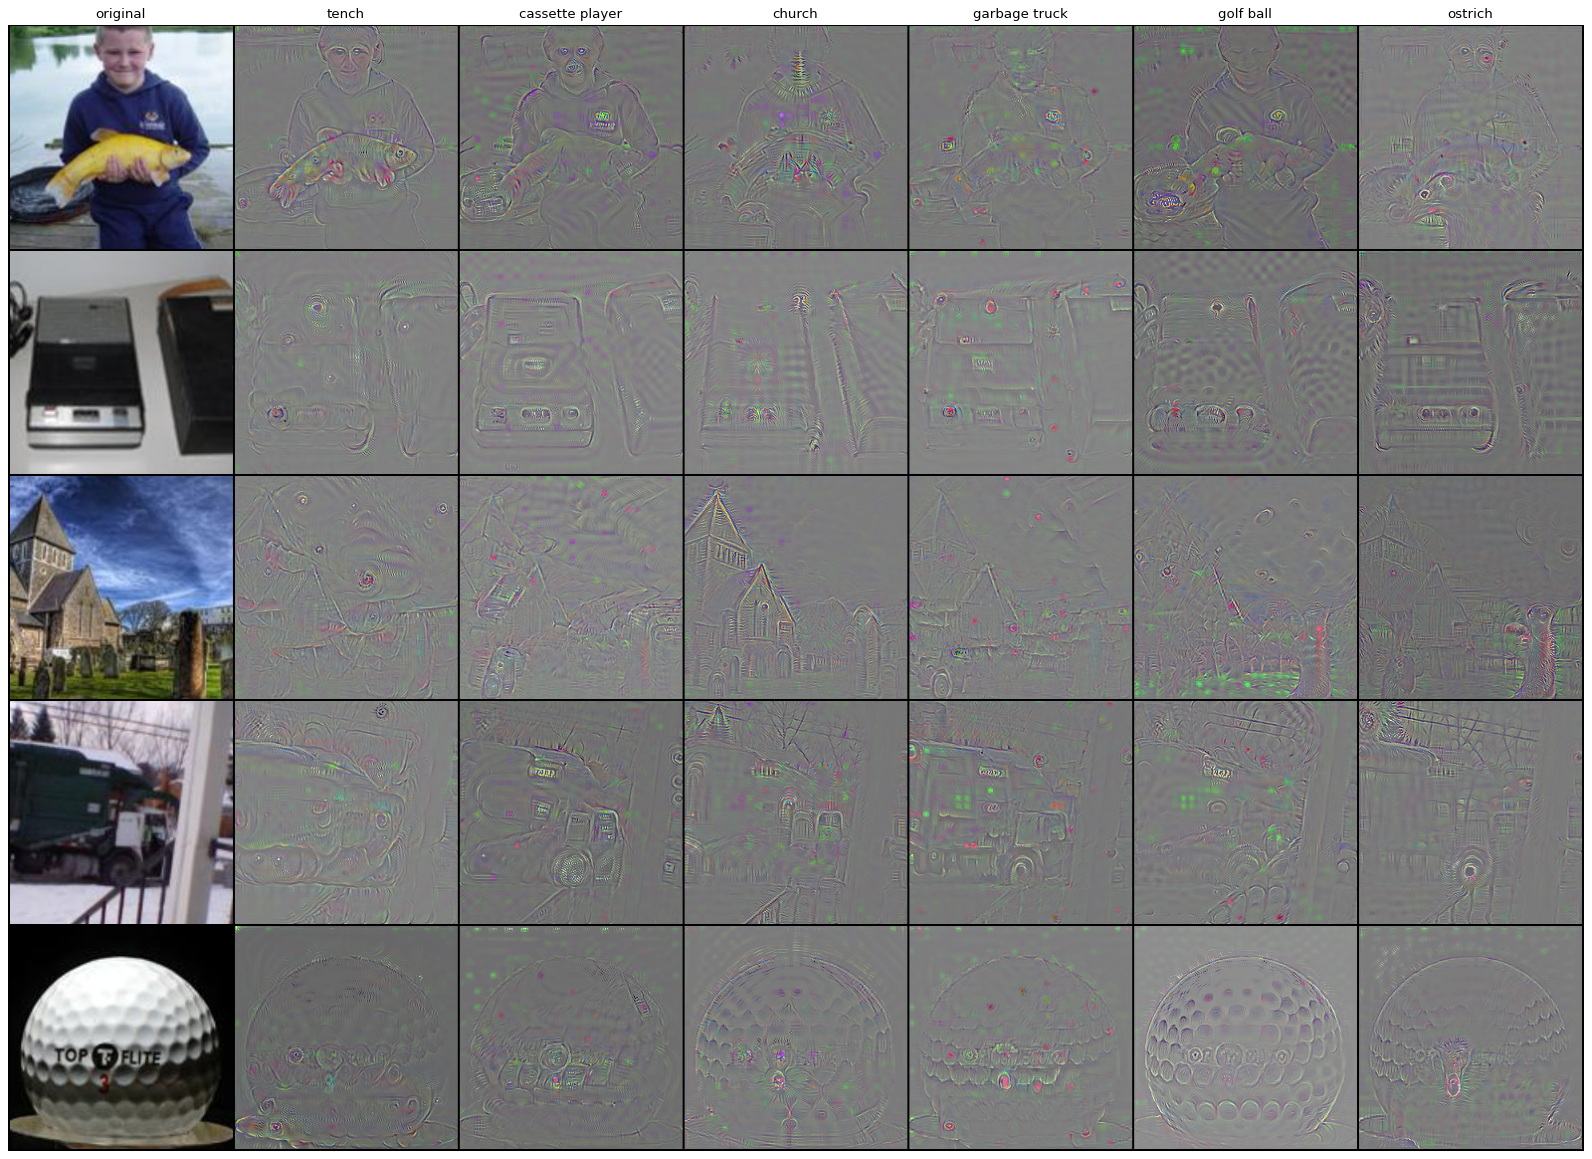

In [62]:
# plot_example_grid(show_diff_std, nrow=7, column_titles=class_names, save_path=f"media/diff_{model_cls.__name__}_alpha_{alpha}_steps_{steps}_std.jpg", dpi=80)
plot_example_grid(show_diff, nrow=7, column_titles=class_names, save_path=f"media/diff_{model_cls.__name__}_alpha_{alpha}_steps_{steps}.jpg", dpi=80)

In [ ]:
# plot_example_grid(show_adv_std, nrow=7, column_titles=class_names, save_path=f"media/adv_{model_cls.__name__}_alpha_{alpha}_steps_{steps}_std.jpg", dpi=80)
plot_example_grid(show_adv, nrow=7, column_titles=class_names, save_path=f"media/adv_{model_cls.__name__}_alpha_{alpha}_steps_{steps}.jpg", dpi=80)

In [ ]:
plot_example_grid(show_diff_std, nrow=7, column_titles=class_names, save_path=f"media/diff_{model_cls.__name__}_alpha_{alpha}_steps_{steps}_std.jpg", dpi=80)
# plot_example_grid(show_diff, nrow=7, column_titles=class_names, save_path=f"media/diff_{model_cls.__name__}_alpha_{alpha}_steps_{steps}.jpg", dpi=80)

In [ ]:
plot_example_grid(show_adv_std, nrow=7, column_titles=class_names, save_path=f"media/adv_{model_cls.__name__}_alpha_{alpha}_steps_{steps}_std.jpg", dpi=80)
# plot_example_grid(show_adv, nrow=7, column_titles=class_names, save_path=f"media/adv_{model_cls.__name__}_alpha_{alpha}_steps_{steps}.jpg", dpi=80)